In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib
import re

sns.set(style="whitegrid")


In [2]:
import shap


In [3]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score


In [4]:
url = "https://raw.githubusercontent.com/emilyburr7/horse-race-times-ml/main/data/raceform_small.csv"
df = pd.read_csv(url)
df.head()


,date,course,race_id,off,race_name,type,class,pattern,rating_band,age_band,...,trainer,prize,or,rpr,ts,sire,dam,damsire,owner,comment
0,2022-04-02,Saint-Cloud (FR),809089,2:15,Prix du Languedoc (Handicap) (4yo+) (Turf),Flat,NaN,NaN,NaN,4yo+,...,D Smaga,NaN,–,87,41,Whipper (USA),Envoutement (FR),Vettori,Alain Louis Dreyfus,NaN
1,2021-06-03,Longchamp (FR),786801,6:00,Prix du Val de Grace (Claimer) (4yo+) (Moyenne...,Flat,NaN,NaN,NaN,4yo+,...,E Lyon,NaN,–,47,21,Kingsalsa (USA),Ma Bonne Etoile (FR),Medaaly,Roland Monnier,NaN
2,2015-03-21,Tampa Bay Downs (USA),621984,7:40,Maiden Special Weight (3yo) (Turf),Flat,NaN,NaN,NaN,3yo,...,Michele Boyce,2564.1,–,–,–,City Zip (USA),Jelly Roll (USA),Smart Strike,Caroline Mansour Cherrywood Racing Stables Ii,NaN
3,2021-01-29,Chantilly (FR),777313,2:05,Prix de Noisy-Sur-Oise (Handicap) (5yo+) (All-...,Flat,NaN,NaN,NaN,5yo+,...,D Smaga,NaN,–,64,–,Rip Van Winkle (IRE),Victoria College (FR),Rock Of Gibraltar,David Smaga,NaN
4,2022-11-06,Sandown,822748,12:50,Jumps Are Back Conditional Jockeys Handicap Hu...,Hurdle,Class 3,NaN,0-130,3yo+,...,Nigel Twiston-Davies,2835.17,110,115,52,Fame And Glory (GB),Glory Days (GER),Tiger Hill,Charles C Walker,Took keen hold - in rear - slow jump 4th - not...


In [5]:
# HELPER FUNCTIONS FOR FEATURE ENGINEERING

def time_to_seconds(t):
    if pd.isna(t):
        return np.nan
    t = str(t).strip()
    if ":" in t:
        parts = t.split(":")
        try:
            minutes = float(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        except:
            return np.nan
    match = re.match(r'(?:(\d+)m)?\s*(\d+(?:\.\d+)?)s', t)
    if match:
        minutes = float(match.group(1)) if match.group(1) else 0
        seconds = float(match.group(2))
        return minutes * 60 + seconds
    return np.nan


def parse_fraction(text):
    fractions = {'½': 0.5, '¼': 0.25, '¾': 0.75}
    for f, v in fractions.items():
        text = text.replace(f, f"+{v}")
    return text

def convert_distance(d):
    if pd.isna(d):
        return np.nan
    d = str(d).strip()
    d = parse_fraction(d)
    miles, furlongs = 0, 0
    if 'm' in d:
        parts = d.split('m')
        try:
            miles = eval(parts[0])
        except:
            miles = np.nan
        if 'f' in parts[1]:
            try:
                furlongs = eval(parts[1].replace('f', ''))
            except:
                furlongs = np.nan
    elif 'f' in d:
        try:
            furlongs = eval(d.replace('f', ''))
        except:
            furlongs = np.nan
    return miles * 8 + furlongs

def weight_to_lbs(w):
    if pd.isna(w):
        return np.nan
    if '-' not in str(w):
        return np.nan
    st, lbs = str(w).split('-')
    return int(st) * 14 + int(lbs)


In [6]:
df['time_seconds'] = df['time'].apply(time_to_seconds)
df['distance_f'] = df['dist'].apply(convert_distance)
df['weight_lbs'] = df['wgt'].apply(weight_to_lbs)
df['pace'] = df['time_seconds'] / df['distance_f']
df[['time', 'time_seconds', 'dist', 'distance_f', 'wgt', 'weight_lbs', 'pace']].head()


,time,time_seconds,dist,distance_f,wgt,weight_lbs,pace
0,2:11.25,131.25,1m2f,10.0,9-4,130,13.12500
1,2:8.17,128.17,1m2f,10.0,9-1,127,12.81700
2,1:36.26,96.26,1m,8.0,8-8,120,12.03250
3,1:40.67,100.67,1m,8.0,8-11,123,12.58375
4,5:25.85,325.85,2m4f,20.0,10-6,146,16.29250


In [7]:
df['ts'] = pd.to_numeric(df['ts'], errors='coerce')

target = "ts"
features = ["distance_f", "age", "weight_lbs", "going", "course"]

base_cols = features + [target]
df_model = df[base_cols].dropna().copy()

df_model["pace"] = df.loc[df_model.index, "pace"]
df_model["race_id"] = df.loc[df_model.index, "race_id"]

X = df_model[features]
y = df_model[target]
y_pace = df_model["pace"]
groups = df_model["race_id"]

print("Final modeling dataframe shape:", df_model.shape)
display(X.head())
display(y.head())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


Final modeling dataframe shape: (33009, 8)


,distance_f,age,weight_lbs,going,course
0,10.0,9,130,Soft,Saint-Cloud (FR)
1,10.0,5,127,Good,Longchamp (FR)
4,20.0,6,146,Heavy,Sandown
5,17.0,4,149,Good,Wexford (IRE)
6,16.0,5,156,Good To Soft,Ffos Las


,ts
0,41.0
1,21.0
4,52.0
5,68.0
6,1.0


In [8]:
numeric_features = ["distance_f", "age", "weight_lbs"]
categorical_features = ["going", "course"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
         categorical_features),
    ],
    sparse_threshold=0  # force dense output
)


In [9]:
# BASELINE MODEL: PREDICT MEAN ts

y_mean = y_train.mean()
y_baseline_pred = np.full_like(y_test, fill_value=y_mean, dtype=float)

print("Baseline (Mean) Results:")
print("MAE:", mean_absolute_error(y_test, y_baseline_pred))

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_baseline_pred))
print("RMSE:", rmse_baseline)

print("R²:", r2_score(y_test, y_baseline_pred))


Baseline (Mean) Results:
MAE: 21.466809901769892
RMSE: 26.791767399135075
R²: -3.7960444199125476e-06


In [10]:
# LINEAR REGRESSION MODEL + 5-FOLD CV

lr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# 5-fold CV on the full dataset (X, y)
cv_mae_lr = -cross_val_score(
    lr_model, X, y,
    cv=5,
    scoring="neg_mean_absolute_error"
)
cv_r2_lr = cross_val_score(
    lr_model, X, y,
    cv=5,
    scoring="r2"
)

print("Linear Regression 5-fold CV MAE (mean ± std):",
      cv_mae_lr.mean(), "±", cv_mae_lr.std())
print("Linear Regression 5-fold CV R² (mean ± std):",
      cv_r2_lr.mean(), "±", cv_r2_lr.std())

# Fit on train split and evaluate on test split
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("\nLinear Regression Test Results:")
print("MAE:", mean_absolute_error(y_test, lr_pred))
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_pred))
print("RMSE:", rmse_lr)
print("R²:", r2_score(y_test, lr_pred))


Linear Regression 5-fold CV MAE (mean ± std): 18.773901274653262 ± 0.20448160436466262
Linear Regression 5-fold CV R² (mean ± std): 0.2363208350030252 ± 0.011877733882992146

Linear Regression Test Results:
MAE: 18.893068317982117
RMSE: 23.410437271991295
R²: 0.23648429977793528


In [11]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=5)

ridge_g = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Ridge(alpha=0.1))
])

rf_g = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=80,
        random_state=42,
        n_jobs=-1
    ))
])

rows_g = []

for name, model in [("Ridge", ridge_g), ("RF", rf_g)]:
    mae_scores = -cross_val_score(
        model, X, y,
        groups=groups,
        cv=gkf,
        scoring="neg_mean_absolute_error"
    )
    r2_scores = cross_val_score(
        model, X, y,
        groups=groups,
        cv=gkf,
        scoring="r2"
    )
    rows_g.append({
        "model": name,
        "gkf_MAE": mae_scores.mean(),
        "gkf_R2": r2_scores.mean()
    })

groupcv_results = pd.DataFrame(rows_g)
groupcv_results


,model,gkf_MAE,gkf_R2
0,Ridge,18.776038,0.236160
1,RF,19.635332,0.154156


In [12]:
ridge_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=0.1))
])

lasso_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Lasso(alpha=0.01, max_iter=10000))
])

knn_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsRegressor(n_neighbors=11))
])

gb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(n_estimators=400, learning_rate=0.05))
])


In [13]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=80,
        random_state=42,
        n_jobs=-1
    ))
])


In [14]:
# small subset for quick CV
X_cv = X_train.sample(2000, random_state=42)
y_cv = y_train.loc[X_cv.index]

models = {
    "Linear": lr_model,
    "Ridge": ridge_model,
    "Lasso": lasso_model,
    "kNN": knn_model,
    "RandomForest": rf_model,
    "GradientBoosting": gb_model,
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

rows = []
for name, model in models.items():
    mae_scores = cross_val_score(
        model, X_cv, y_cv,
        scoring="neg_mean_absolute_error",
        cv=cv
    )
    r2_scores = cross_val_score(
        model, X_cv, y_cv,
        scoring="r2",
        cv=cv
    )
    rows.append({
        "model": name,
        "cv_MAE": -mae_scores.mean(),
        "cv_R2": r2_scores.mean()
    })

cv_results = pd.DataFrame(rows)
cv_results


,model,cv_MAE,cv_R2
0,Linear,19.223890,0.198708
1,Ridge,19.202728,0.200608
2,Lasso,19.069925,0.211947
3,kNN,20.125465,0.125254
4,RandomForest,19.746542,0.156820
5,GradientBoosting,19.192790,0.208781


In [15]:
X_rf = X_train.sample(8000, random_state=42)
y_rf = y_train.loc[X_rf.index]

rf_model.fit(X_rf, y_rf)
rf_pred = rf_model.predict(X_test)

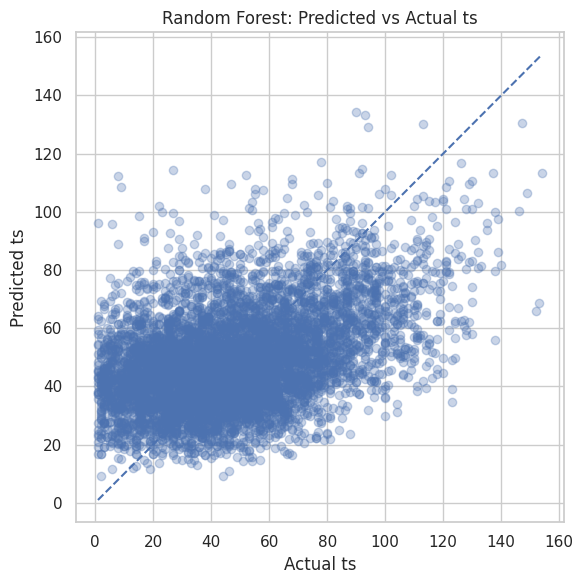

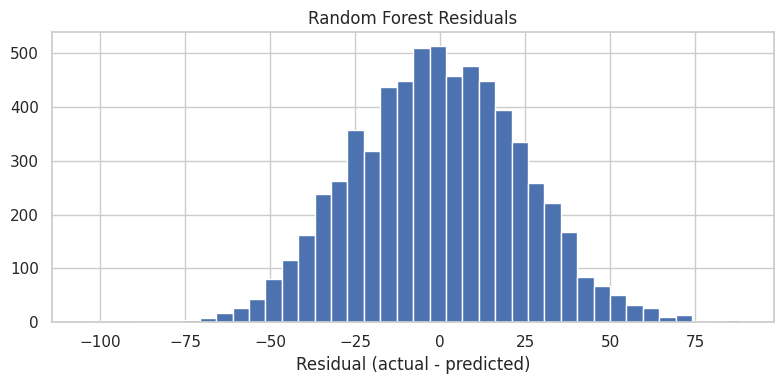

In [16]:
# RF DIAGNOSTIC PLOTS

# 1. Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, rf_pred, alpha=0.3)
plt.xlabel("Actual ts")
plt.ylabel("Predicted ts")
plt.title("Random Forest: Predicted vs Actual ts")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.tight_layout()
plt.savefig("rf_pred_vs_actual.png")
plt.show()

# 2. Residuals histogram
residuals = y_test - rf_pred

plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=40)
plt.xlabel("Residual (actual - predicted)")
plt.title("Random Forest Residuals")
plt.tight_layout()
plt.savefig("rf_residuals_hist.png")
plt.show()


In [17]:
X_small = X_train.sample(8000, random_state=0)
y_small = y_train.loc[X_small.index]

test_rows = []

for name, model in models.items():
    model.fit(X_small, y_small)
    preds = model.predict(X_test)
    test_rows.append({
        "model": name,
        "test_MAE": mean_absolute_error(y_test, preds),
        "test_RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "test_R2": r2_score(y_test, preds)
    })

test_results = pd.DataFrame(test_rows)
test_results


,model,test_MAE,test_RMSE,test_R2
0,Linear,19.042492,23.594964,0.224400
1,Ridge,19.041962,23.594036,0.224461
2,Lasso,19.060217,23.590273,0.224709
3,kNN,20.068519,24.949460,0.132796
4,RandomForest,19.926358,24.800368,0.143130
5,GradientBoosting,19.123314,23.615225,0.223068


In [18]:
ablation_configs = {
    "numeric_only": ["distance_f", "age", "weight_lbs"],
    "numeric_going": ["distance_f", "age", "weight_lbs", "going"],
    "full_features": ["distance_f", "age", "weight_lbs", "going", "course"]
}

ablation_rows = []

for name, feats in ablation_configs.items():
    X_ab = df_model[feats]
    y_ab = df_model["ts"]

    X_train_ab, X_test_ab, y_train_ab, y_test_ab = train_test_split(
        X_ab, y_ab, test_size=0.20, random_state=42
    )

    pre_ab = ColumnTransformer(
        transformers=[
            ("num", "passthrough", [f for f in feats if f in numeric_features]),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
             [f for f in feats if f in categorical_features])
        ],
        sparse_threshold=0
    )

    model_ab = Pipeline(steps=[
        ("pre", pre_ab),
        ("ridge", Ridge(alpha=0.1))
    ])

    model_ab.fit(X_train_ab, y_train_ab)
    preds_ab = model_ab.predict(X_test_ab)

    ablation_rows.append({
        "model": name,
        "MAE": mean_absolute_error(y_test_ab, preds_ab),
        "RMSE": np.sqrt(mean_squared_error(y_test_ab, preds_ab)),
        "R2": r2_score(y_test_ab, preds_ab)
    })

ablation_results = pd.DataFrame(ablation_rows)
ablation_results


,model,MAE,RMSE,R2
0,numeric_only,19.783810,24.507827,0.163225
1,numeric_going,19.602724,24.292715,0.177850
2,full_features,18.893086,23.410288,0.236494


In [19]:
bins = [0, 7, 10, 100]
labels = ["short", "medium", "long"]

test_df = X_test.copy()
test_df["ts_actual"] = y_test
test_df["ts_pred"] = rf_pred
test_df["abs_error"] = (test_df["ts_actual"] - test_df["ts_pred"]).abs()
test_df["distance_group"] = pd.cut(test_df["distance_f"], bins=bins, labels=labels)

distance_results = (
    test_df
    .groupby("distance_group")["abs_error"]
    .mean()
    .reset_index()
    .rename(columns={"abs_error": "MAE"})
)

distance_results


/tmp/ipython-input-3016048108.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("distance_group")["abs_error"]


,distance_group,MAE
0,short,17.389997
1,medium,17.939186
2,long,22.831209


In [27]:
bins = [0, 7, 10, 100]
labels = ["short", "medium", "long"]

df_model["distance_group"] = pd.cut(df_model["distance_f"], bins=bins, labels=labels)

group_means = (
    df_model
    .groupby(["course", "distance_group"])["ts"]
    .mean()
    .reset_index()
    .rename(columns={"ts": "mean_ts"})
)

test_df = X_test.copy()
test_df["ts_actual"] = y_test

test_df["distance_group"] = pd.cut(test_df["distance_f"], bins=bins, labels=labels)

test_df = test_df.merge(group_means, on=["course", "distance_group"], how="left")

test_df["ts_pred_baseline2"] = test_df["mean_ts"]
test_df["abs_error_baseline2"] = (test_df["ts_actual"] - test_df["ts_pred_baseline2"]).abs()

baseline2_mae = test_df["abs_error_baseline2"].mean()
baseline2_mae



/tmp/ipython-input-3804234888.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["course", "distance_group"])["ts"]


np.float64(19.449297116766843)

In [20]:
df_pace = df_model.dropna(subset=["pace"]).copy()

X_p = df_pace[features]
y_p = df_pace["pace"]


In [21]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_p, y_p, test_size=0.20, random_state=42
)

ridge_pace = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=0.1))
])

rf_pace = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=80,
        random_state=42,
        n_jobs=-1
    ))
])

ridge_pace.fit(X_train_p, y_train_p)
rf_pace.fit(X_train_p, y_train_p)

ridge_pace_pred = ridge_pace.predict(X_test_p)
rf_pace_pred = rf_pace.predict(X_test_p)

print("Ridge pace MAE:", mean_absolute_error(y_test_p, ridge_pace_pred))
print("Ridge pace RMSE:", np.sqrt(mean_squared_error(y_test_p, ridge_pace_pred)))
print("Ridge pace R2:", r2_score(y_test_p, ridge_pace_pred))

print("Random Forest pace MAE:", mean_absolute_error(y_test_p, rf_pace_pred))
print("Random Forest pace RMSE:", np.sqrt(mean_squared_error(y_test_p, rf_pace_pred)))
print("Random Forest pace R2:", r2_score(y_test_p, rf_pace_pred))


Ridge pace MAE: 0.3266059104313009
Ridge pace RMSE: 0.42976159779357015
Ridge pace R2: 0.9119820856240771
Random Forest pace MAE: 0.2677968785950714
Random Forest pace RMSE: 0.3615762067933628
Random Forest pace R2: 0.9376960543457664


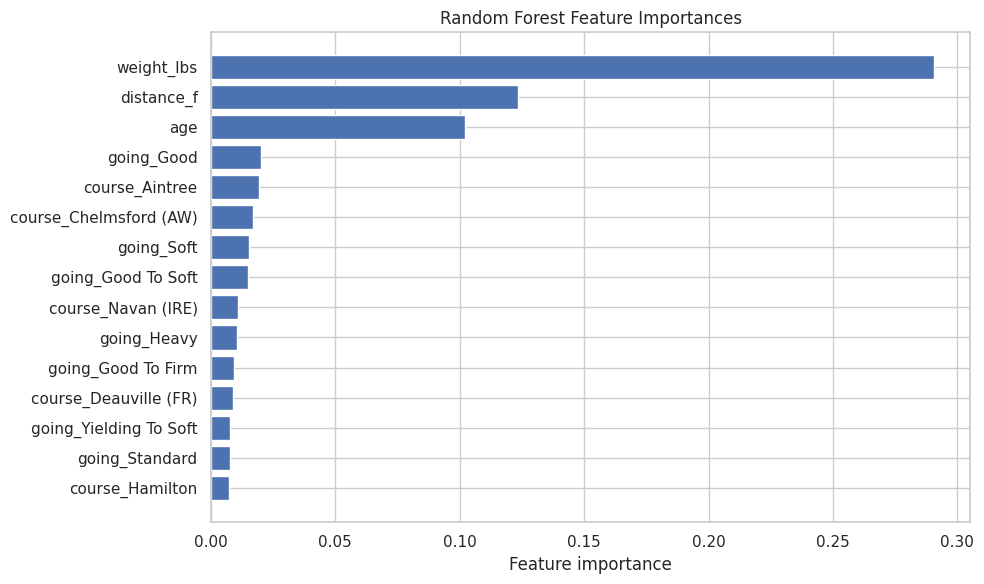

In [22]:
rf_regressor = rf_model.named_steps["model"]

pre = rf_model.named_steps["preprocess"]
cat_encoder = pre.named_transformers_["cat"]

feature_names_num = numeric_features
feature_names_cat = cat_encoder.get_feature_names_out(categorical_features).tolist()
feature_names = feature_names_num + feature_names_cat

importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 15
indices = indices[:top_k]

plt.figure(figsize=(10, 6))
plt.barh(
    range(len(indices)),
    importances[indices][::-1]
)
plt.yticks(
    range(len(indices)),
    [feature_names[i] for i in indices][::-1]
)
plt.xlabel("Feature importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.savefig("rf_feature_importance.png")
plt.show()


In [23]:
# SHAP summary (skipped due to runtime)
# shap.initjs()
# X_shap = X_test.sample(500, random_state=0)
# X_shap_trans = rf_model.named_steps["preprocess"].transform(X_shap)
# rf_est = rf_model.named_steps["model"]
# explainer = shap.TreeExplainer(rf_est, feature_perturbation="tree_path_dependent")
# shap_values = explainer.shap_values(X_shap_trans)
# shap.summary_plot(shap_values, X_shap_trans, feature_names=feature_names)


In [24]:
# SAVE MODEL + REQUIREMENTS

joblib.dump(rf_model, "rf_model.pkl")

requirements = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "joblib"
]
print("Project requirements:", requirements)


Project requirements: ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'joblib']


In [25]:
# tiny RF model on numeric features only (for upload)

numeric_only = ["distance_f", "age", "weight_lbs"]

X_small = df_model[numeric_only].sample(5000, random_state=42)
y_small = df_model.loc[X_small.index, "ts"]

from sklearn.ensemble import RandomForestRegressor
import joblib
from google.colab import files

small_rf = RandomForestRegressor(
    n_estimators=80,
    random_state=42,
    n_jobs=-1
)

small_rf.fit(X_small, y_small)

joblib.dump(small_rf, "rf_model_small.pkl", compress=3)

files.download("rf_model_small.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>